# Imports

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_style('white')

# Data Cleaning

In [2]:
conn = sqlite3.connect('Data/HMTG_possib_remote_pilot1.db')
dat = pd.read_sql_query('SELECT * FROM trials A INNER JOIN subjects B ON A.subject_id = B.id WHERE B.bonus NOTNULL', conn)
dat = dat.astype({'trl': int})


### Make sure all subjects have 45 trials. group by trustee observed

In [3]:
# Drop any subject with less than 45 trials
for trustee in dat.trustee_id.unique():
    for subject in dat.loc[dat.trustee_id == trustee].subject_id.unique():
        if dat.loc[dat.subject_id==subject].trl.max() != 44:
            dat.drop(dat.index[dat['subject_id'] == subject], inplace=True)

dat = dat.loc[dat.subID != 'prolific_subject'].reset_index(drop=True)

# Add Trustee Strategy
p2s = {54:'opportunist', 62:'greedy', 93:'GA', 97:'IA'}
dat['p2_strategy'] = dat.trustee_id.apply(lambda x: p2s[x])

sub_count = dat.groupby('trustee_id').agg(({"subject_id": "nunique"}))
sub_count

,subject_id
trustee_id,
54,19
62,19
93,22
97,13


### Make sure each trustee was observed by the same number of subject

In [4]:
# Ensure that each trustee was viewed by the same amount of subjects
n = sub_count.subject_id.min()

for trustee in dat.trustee_id.unique():
    subs_x_trustee = len(dat.loc[dat.trustee_id == trustee].subject_id.unique()) # number of subjects who viewed a single trustee
    if subs_x_trustee > n:
        indx2drop = np.random.choice(range(subs_x_trustee), size=(subs_x_trustee-n), replace=False) #pick random indices to drop
        subs2drop = dat.loc[dat.trustee_id == trustee].subject_id.unique()[indx2drop]  #find the subjects corresponding to random indices

        [dat.drop(dat.index[dat['subject_id'] == ss], inplace=True) for ss in subs2drop] # drop extras
dat.groupby('trustee_id').agg(({"subject_id": "nunique"}))

,subject_id
trustee_id,
54,13
62,13
93,13
97,13


### Count the number of probe trials

In [5]:
dat['probe_trl'] = dat.reason != 'n/a'

dat['probe_num'] = np.nan

for subject in dat.subject_id.unique():
    t = 0
    for rr in dat.loc[(dat.subject_id == subject) & (dat.probe_trl == True)].iterrows():
        dat.loc[(dat.subject_id == subject) & (dat.trl == rr[1].trl), 'probe_num'] = t
        t += 1


# Compute and Plot Prediction Errors

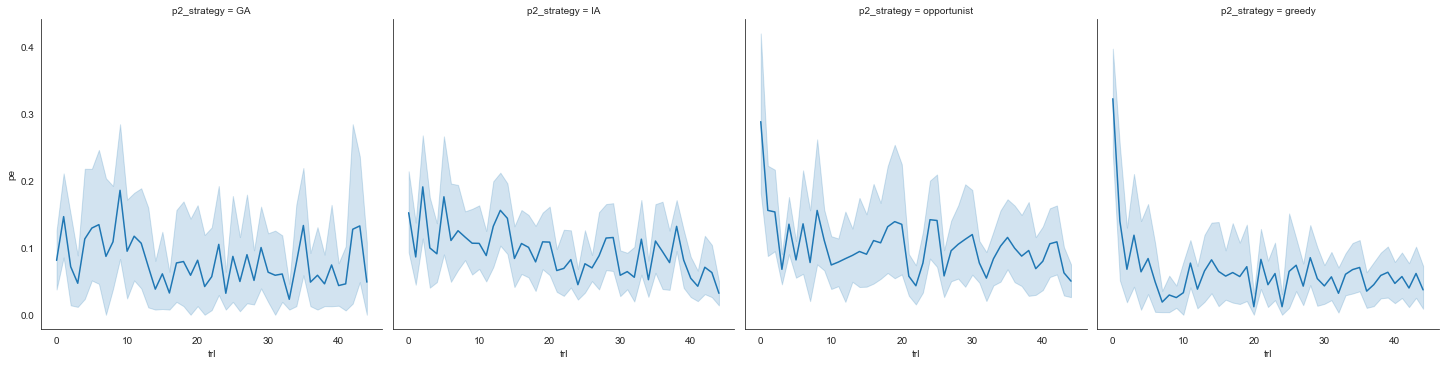

In [6]:
# Make errors between 0 and 1
dat['pe'] = abs((dat.pred/(dat.mult*dat.inv)) - (dat.ret/(dat.mult*dat.inv)))
sns.relplot(x='trl', y='pe', data=dat, col='p2_strategy', kind='line')


# Make sure probes evenly spaced

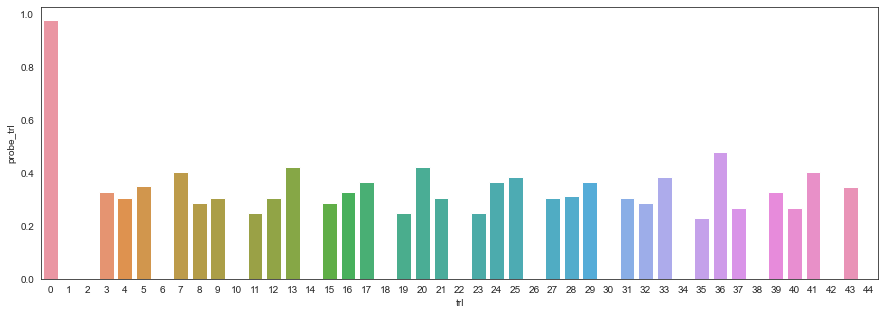

In [7]:
f, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=dat, x='trl', y='probe_trl', ci=None)

# Let's try NLP stuff FML

In [8]:
#from absl-py import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

def embed(input):
  return model(input)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Subject response similarity over time (within Trustee)

### Get average response embedding
Get mean embedding for each probe across subjects observing the same Trustee

In [9]:
dat.sort_values(['subject_id', 'trl'], inplace=True)

def get_embedding(across='trustee_id'):
    '''

    :param across: str: column in the dataframe over which to average embeddings. e.g across='trustee' will compute average embedding (at each probe #) across all subjects who observed the same trustee.
    :return: dict: mapping value of 'across' argument to a (n, 512) tensor where n = the number of probes across the "across" variable.
    e.g. if by == 'mult', n = number of times a probe followed 2,4, or 6 trials.
    '''
    temp = {}
    for bb in tqdm(dat[across].unique()):
        subs = dat.loc[(dat[across] == bb) & (dat.probe_trl == True)]
        probe_embeddings = []
        for p in range(int(subs.probe_num.max())):
            e0 = embed(subs.loc[subs.probe_num == p].reason.values.tolist())
            probe_embeddings.append(e0.numpy().mean(axis=0)) # average embedding of p_th probe across subjects viewing the same trustee
        temp[bb] = probe_embeddings
    return temp
temp = get_embedding(across='trustee_id')


dict_keys([2, 4, 6])

In [ ]:

for item in across:
    temp = {}
    for bb in tqdm(dat[item].unique()):
        subs = dat.loc[(dat[item] == bb) & (dat.probe_trl == True)]
        probe_embeddings = []
        for p in range(int(subs.probe_num.max())):
            e0 = embed(subs.loc[subs.probe_num == p].reason.values.tolist())
            probe_embeddings.append(e0.numpy().mean(axis=0)) # average embedding of p_th probe across subjects viewing the same trustee
        temp[bb] = probe_embeddings

In [10]:
sims = pd.DataFrame(columns=range(int(dat.probe_num.max())))
sims['p2_strategy'] = ''


for p2id, strat in p2s.items():
    probe_embeddings = temp[p2id]
    xx = pd.DataFrame(index=range(len(probe_embeddings)), columns=range(len(probe_embeddings)))
    for tt in range(len(probe_embeddings)):
        for ii in range(len(probe_embeddings)):
            xx.at[tt, ii] =  np.linalg.norm(probe_embeddings[tt] - probe_embeddings[ii])

    for col in xx.columns:
        xx[col] = xx[col].astype(float) # not sure why seaborn makes me do this

    xx['p2_strategy'] = strat
    sims = sims.append(xx)

100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


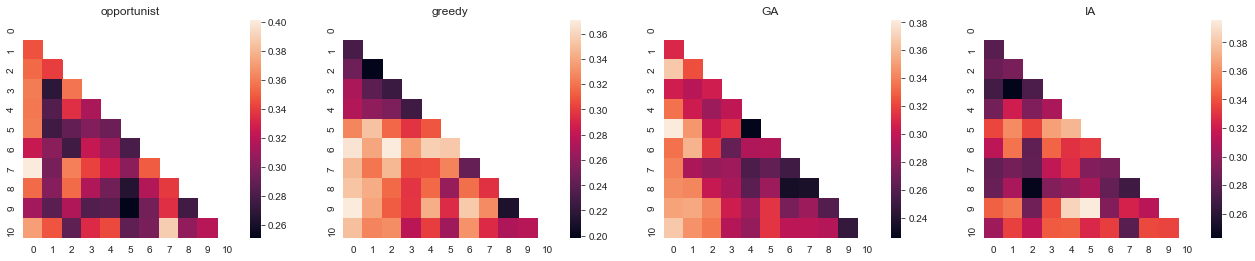

In [11]:

fig, ax = plt.subplots(figsize=(22,4), nrows=1, ncols=4)
for ii, strat  in enumerate(p2s.values()):
    yy = sims.loc[sims.p2_strategy == strat].drop('p2_strategy', axis=1)
    mask = np.zeros_like(yy.to_numpy(dtype='float64'))
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(yy, ax=ax[ii], mask=mask)
    ax[ii].set_title(strat)

## Response similarity over time across multipliers

In [16]:
mult_emb = get_embedding(across="mult")
sims = pd.DataFrame(columns=range(int(dat.probe_num.max())))


for i, m in enumerate([2, 4, 6]):
    probe_embeddings = mult_emb[m]
    xx = pd.DataFrame(index=range(len(probe_embeddings)), columns=range(len(probe_embeddings)))
    for tt in range(len(probe_embeddings)):
        for ii in range(len(probe_embeddings)):
            xx.at[tt, ii] =  np.linalg.norm(probe_embeddings[tt] - probe_embeddings[ii])

    for col in xx.columns:
        xx[col] = xx[col].astype(float) # not sure why seaborn makes me do this

    xx['mult'] = m
    sims = sims.append(xx)

100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


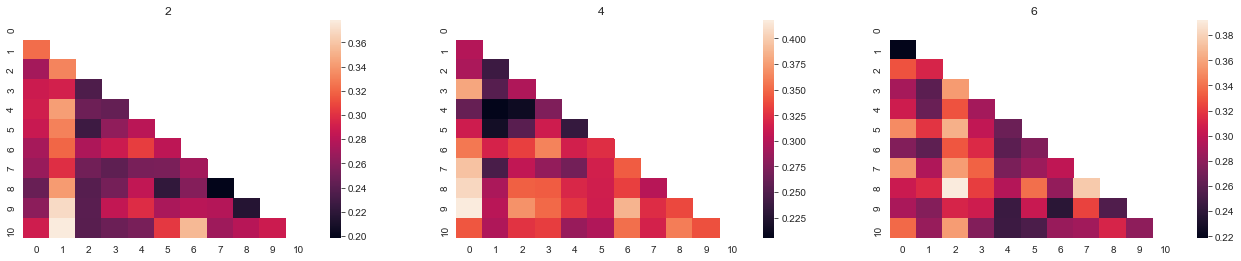

In [18]:
fig, ax = plt.subplots(figsize=(22,4), nrows=1, ncols=3)
for ii, mm  in enumerate([2, 4, 6]):
    yy = sims.loc[sims.mult == mm].drop('mult', axis=1)
    mask = np.zeros_like(yy.to_numpy(dtype='float64'))
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(yy, ax=ax[ii], mask=mask)
    ax[ii].set_title(mm)

## Response Similarity across Trustee AND multiplier

In [32]:
across = ['trustee_id', 'mult']
p2 = across[0]
m = across[1]

out_dict = {t: {m:None for m in dat[m].unique()} for t in dat[p2].unique()}
for trustee in dat[p2].unique():
    first = dat.loc[(dat[p2] == trustee) & (dat.probe_trl == True)]
    for mm in dat[m].unique():
        probe_embeddings = []
        second = first.loc[first[m] == mm]
        for p in range(int(second.probe_num.max())):
            msgs = second.loc[second.probe_num == p].reason.values.tolist()
            if len(msgs)> 0:
                e0 = embed(second.loc[second.probe_num == p].reason.values.tolist())
                probe_embeddings.append(e0.numpy().mean(axis=0))
        out_dict[trustee][mm] = probe_embeddings


In [34]:
sims = pd.DataFrame(columns=range(int(dat.probe_num.max())))

for trust in out_dict.keys():
    for i, m in enumerate([2, 4, 6]):
        probe_embeddings = out_dict[trust][m]
        xx = pd.DataFrame(index=range(len(probe_embeddings)), columns=range(len(probe_embeddings)))
        for tt in range(len(probe_embeddings)):
            for ii in range(len(probe_embeddings)):
                xx.at[tt, ii] =  np.linalg.norm(probe_embeddings[tt] - probe_embeddings[ii])

        for col in xx.columns:
            xx[col] = xx[col].astype(float) # not sure why seaborn makes me do this

        xx['mult'] = m
        xx['p2'] = p2s[trust]
        sims = sims.append(xx)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc15ca76910>,
      dtype=object)

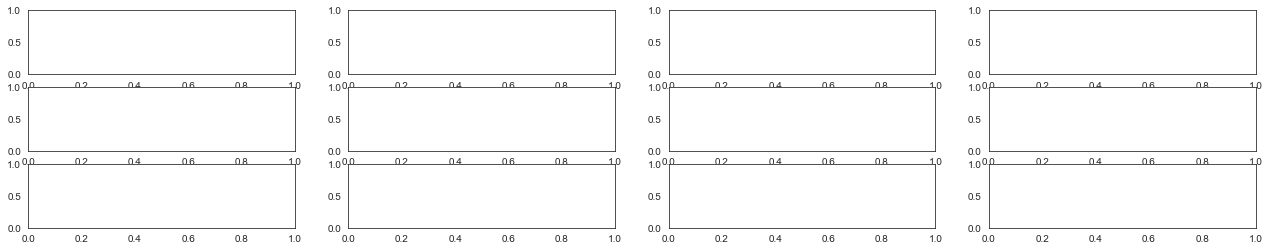

In [35]:
ax

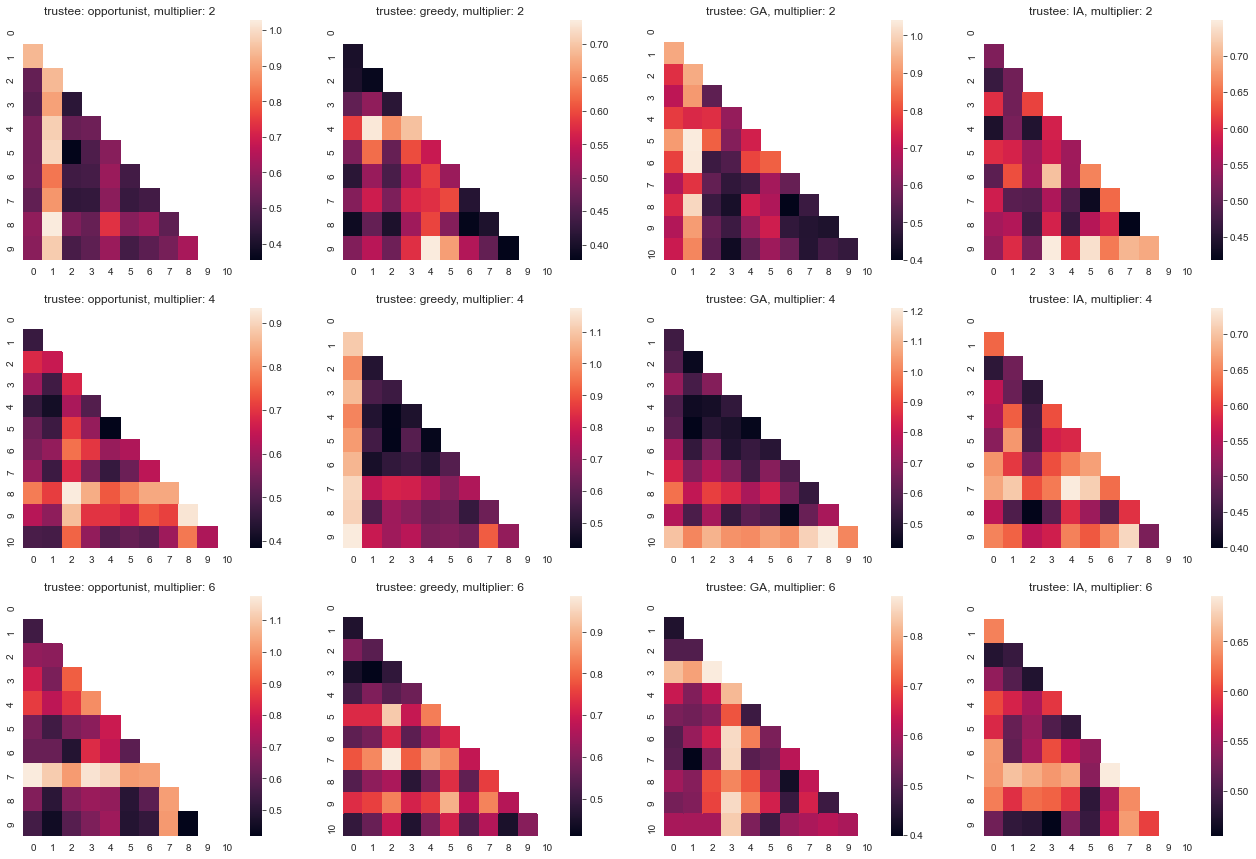

In [36]:
fig, ax = plt.subplots(figsize=(22,15), nrows=3, ncols=4)

for tti, tt in enumerate(p2s.values()):
    for ii, mm  in enumerate([2, 4, 6]):
        yy = sims.loc[(sims.p2 == tt ) & (sims.mult == mm)].drop(['mult', 'p2'], axis=1)
        mask = np.zeros_like(yy.to_numpy(dtype='float64'))
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(yy, ax=ax[ii, tti], mask=mask)
        ax[ii, tti].set_title(f'trustee: {tt}, multiplier: {mm}')

## Response Similarity across investment-multipliers

In [38]:
sorted(dat.loc[dat.probe_trl == True].inv.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [40]:
i = 'inv'
m = 'mult'

out_dict = {ii: {m:None for m in dat[m].unique()} for ii in dat[i].unique()}
for invmt in dat[i].unique():
    first = dat.loc[(dat[i] == invmt) & (dat.probe_trl == True)]
    for mm in dat[m].unique():
        probe_embeddings = []
        second = first.loc[first[m] == mm]
        for p in range(int(second.probe_num.max())):
            msgs = second.loc[second.probe_num == p].reason.values.tolist()
            if len(msgs)> 0:
                e0 = embed(second.loc[second.probe_num == p].reason.values.tolist())
                probe_embeddings.append(e0.numpy().mean(axis=0))
        out_dict[invmt][mm] = probe_embeddings

In [42]:
jj = out_dict[10][6]

In [43]:
dat.loc[(dat.inv ==10)&(dat.mult==4)].ret.unique()

array([20, 10, 13, 15,  0,  4])

In [51]:
CFs = {i:{m:{r:None for r in range((i*m)+1)} for m in [2,4,6]} for i in range(1,11)}
CFs[10][2]

{0: None,
 1: None,
 2: None,
 3: None,
 4: None,
 5: None,
 6: None,
 7: None,
 8: None,
 9: None,
 10: None,
 11: None,
 12: None,
 13: None,
 14: None,
 15: None,
 16: None,
 17: None,
 18: None,
 19: None,
 20: None}

In [52]:
for invmt in tqdm(dat[i].unique()):
    first = dat.loc[(dat[i] == invmt) & (dat.probe_trl == True)]
    for mm in dat[m].unique():
        second = first.loc[first[m] == mm]
        for r in range((invmt*mm)+1):
            probe_embeddings = []
            for p in range(int(second.probe_num.max())):
                msgs = second.loc[(second.probe_num == p)& (second.ret == r)].reason.values.tolist()
                if len(msgs)> 0:
                    e0 = embed(second.loc[second.probe_num == p].reason.values.tolist())
                    probe_embeddings.append(e0.numpy().mean(axis=0))
            CFs[invmt][mm][r] = probe_embeddings

100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


In [47]:
ten4 = CFs[10][4][12]

In [55]:
ten4_13 = CFs[10][4][13]

In [ ]:
cf_outcomes = {possib: [mp_model_ppsoe(game.inv[t], game.mult[t], possib[1], possib[0]) for t in range(len(game))] for possib in possibilities}
